In [1]:
import pandas as pd
import pickle
import numpy as np
import re
from sklearn import linear_model


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline              

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import xgboost as xgb    #sklearn不包括xgboost
from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
# 

import os

### 1、数据读取

In [2]:
train=pd.read_csv(r'train.csv', parse_dates=['datetime'])   #将csv中的时间字符串转换成日期格式
test=pd.read_csv(r'test.csv', parse_dates=['datetime'])

* season：季节，1、2、3、4分别代表春夏秋冬；
* holiday：0/1表示是否是节假日；workingday：0/1表示是否是工作日
* weather：1、2、3、4分别表示不同的天气
* temp、atemp表示温度；humidity为湿度；windspeed为风速
* casual：散客需求量；registered：会员需求量
* count：表示最终要预测的自行车需求总量（这一年这一月这一个小时的总需求量）

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
#删除多余的列
train = train.drop(['casual','registered'],axis=1)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [6]:
#定义一个求均方根对数误差的函数
def rmsle(y_log, y0_log):
    return np.sqrt(np.mean(np.square(y_log - y0_log)))

### 2、特征工程

In [7]:
# remove outlier剔除极值（保留每个数据点与平均值之差的绝对值在3个标准差以内的数据）
train = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 

In [8]:
#提取训练集和测试集的年月日小时，获取分布
for df in (train,test):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hr'] = df['datetime'].dt.hour

    #新增一列hr_categori
    df['hr_categori'] = np.nan
    df.loc[(df.workingday == 1)&(df.hr <= 9)&(df.hr >= 7), 'hr_categori'] = "rush"  #工作日早7-9点定义为rush hour（早高峰）
    df.loc[(df.workingday == 1)&(df.hr <= 19)&(df.hr >= 16), 'hr_categori'] = "rush"#下午4-7点也定义为rush hour（晚高峰）
    df.loc[(df.workingday == 1)&(df.hr < 16)&(df.hr > 9), 'hr_categori'] = "day"  #x）
    df.loc[(df.workingday == 1)&(df.hr < 7)|(df.hr > 19), 'hr_categori'] = "night" #晚上7点到第二天早上7点称为night(需求少)

#### hour

D:\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
D:\Anaconda\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


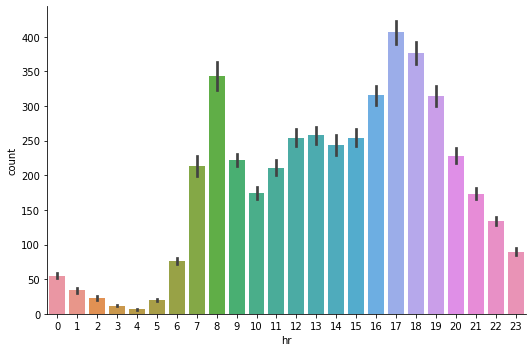

In [9]:
sns.factorplot(x="hr",y="count",data=train,kind='bar',size=5,aspect=1.5)

#### month

1-6月递增，6-12月递减，原数据有季节这个特征

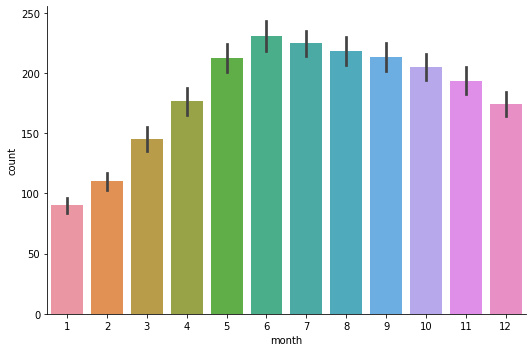

In [10]:
sns.factorplot(x="month",y="count",data=train,kind='bar',size=5,aspect=1.5)

#### year

可能2012年推广更多

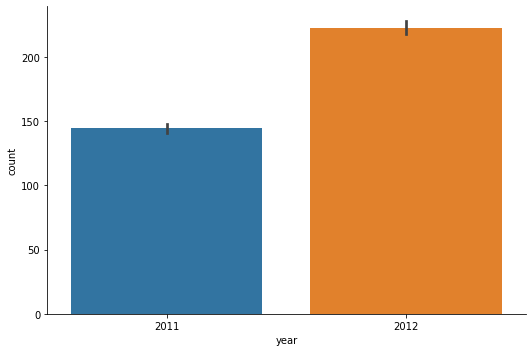

In [11]:
sns.factorplot(x="year",y="count",data=train,kind='bar',size=5,aspect=1.5)

#### temp

最高温度也是13*3=39度，没有极端天气，所以需求随温度的增加而增加。

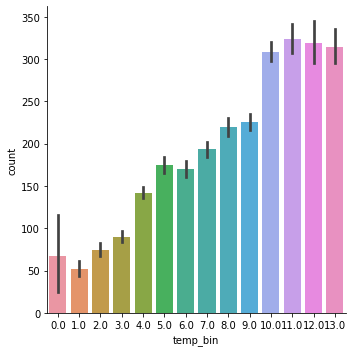

In [12]:
new_df=train.copy()

new_df['temp_bin']=np.floor(new_df['temp'])//3   

sns.factorplot(x="temp_bin",y="count",data=new_df,kind='bar')

#### humidity

在湿度适中的时候需求量最高

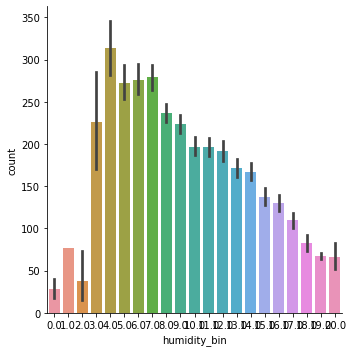

In [13]:
new_df=train.copy()

new_df['humidity_bin']=np.floor(new_df['humidity'])//5

sns.factorplot(x="humidity_bin",y="count",data=new_df,kind='bar')

In [14]:
for df in (train,test):
    
    df['humi_categori'] = np.nan
    df.loc[df.humidity < 15, 'humi_categori'] = 'low'          #湿度低于15的称为low
    df.loc[(df.humidity <= 85)&(df.humidity >= 15), 'humi_categori'] = 'normal'  #湿度大于15低于85的称为normal
    df.loc[(df.humidity >= 85), 'humi_categori'] = 'high'   #湿度大于85的称为high

#### Windspeed

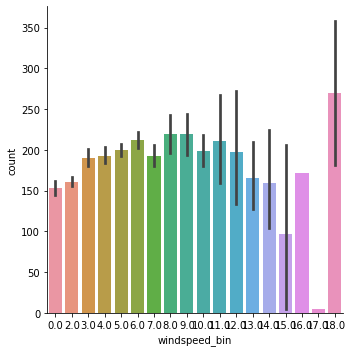

In [15]:
new_df=train.copy()

new_df['windspeed_bin']=np.floor(new_df['windspeed'])//3
sns.factorplot(x="windspeed_bin",y="count",data=new_df,kind='bar')

In [16]:
for df in (train,test):
    
    df['wind_categori'] = np.nan
    df.loc[df.windspeed < 15, 'wind_categori'] = 'normal'
    df.loc[(df.windspeed >= 15), 'wind_categori'] = 'high'

#### one hot encode
对没有大小意义的离散特征取值进行处理，如表示季节的1、2、3、4

In [17]:
weather_train = pd.get_dummies(train['weather'], prefix='wea', prefix_sep='_')
weather_test = pd.get_dummies(test['weather'], prefix='wea', prefix_sep='_')

season_train = pd.get_dummies(train['season'], prefix='sea', prefix_sep='_')
season_test = pd.get_dummies(test['season'], prefix='sea', prefix_sep='_')

year_train = pd.get_dummies(train['year'], prefix='year', prefix_sep='_')
year_test = pd.get_dummies(test['year'], prefix='year', prefix_sep='_')

wind_categori_train = pd.get_dummies(train['wind_categori'], prefix='wind_cate', prefix_sep='_')
wind_categori_test = pd.get_dummies(test['wind_categori'], prefix='wind_cate', prefix_sep='_')

humi_categori_train = pd.get_dummies(train['humi_categori'], prefix='humi_cate', prefix_sep='_')
humi_categori_test = pd.get_dummies(test['humi_categori'], prefix='humi_cate', prefix_sep='_')

hr_categori_train = pd.get_dummies(train['hr_categori'], prefix='hr_cate', prefix_sep='_')
hr_categori_test = pd.get_dummies(test['hr_categori'], prefix='hr_cate', prefix_sep='_')

In [18]:
#合并dataframe
Train_Master = pd.concat([train,
                          weather_train,
                          season_train,
                          year_train,
                          wind_categori_train,
                          humi_categori_train,
                          hr_categori_train
                         ], axis=1)

In [52]:
Train_Master.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,month,day,hr,...,year_2011,year_2012,wind_cate_high,wind_cate_normal,humi_cate_high,humi_cate_low,humi_cate_normal,hr_cate_day,hr_cate_night,hr_cate_rush
0,0,0,9.84,14.395,81,0.0,16,1,1,0,...,1,0,0,1,0,0,1,0,0,0
1,0,0,9.02,13.635,80,0.0,40,1,1,1,...,1,0,0,1,0,0,1,0,0,0
2,0,0,9.02,13.635,80,0.0,32,1,1,2,...,1,0,0,1,0,0,1,0,0,0
3,0,0,9.84,14.395,75,0.0,13,1,1,3,...,1,0,0,1,0,0,1,0,0,0
4,0,0,9.84,14.395,75,0.0,1,1,1,4,...,1,0,0,1,0,0,1,0,0,0


In [19]:
Test_Master = pd.concat([test,
                          weather_test,
                          season_test,
                          year_test,
                          wind_categori_test,
                          humi_categori_test,
                          hr_categori_test
                         ], axis=1)

In [20]:
#将原来不必要的列去掉
Train_Master = Train_Master.drop(['weather','season','year','datetime','hr_categori','humi_categori','wind_categori'], axis = 1)
Test_Master = Test_Master.drop(['weather','season','year','datetime','hr_categori','humi_categori','wind_categori'], axis = 1)

#将数据分为训练集和测试集
Train, Test = train_test_split(Train_Master, test_size = 0.3)

In [21]:
#区分X和Y
X_train = Train.drop(['count'], axis=1)
Y_train = Train['count']
Y_train_log = Train['count'].apply(lambda x:np.log1p(x)) #log1p(x)=log(x+1)，避免出现log(0)使程序中断

X_test = Test.drop(['count'], axis=1)
Y_test = Test["count"]
Y_test_log = Test["count"].apply(lambda x:np.log1p(x))

Y_test = Y_test.reset_index().drop('index',axis = 1)   
Y_train = Y_train.reset_index().drop('index',axis = 1)

### 3、模型自动调参

In [22]:
def lasso_autotune(X,y):

    param_test = {
    'max_iter':[5000],
    'alpha':[1e-10, 1e-8, 1e-4,1e-2, 1, 5, 10, 100, 500, 1000]
    }

    gsearch = GridSearchCV(Lasso(fit_intercept=True, normalize=True, selection='random'),refit=True,
                            param_grid = param_test, scoring='neg_mean_squared_error',iid=True, cv=5)
    gsearch.fit(X,y)
    print('____________________________________________')
    print('tune lasso')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(rmsle(gsearch.predict(X),y))

    return gsearch.best_estimator_

In [23]:
def ridge_autotune(X,y):
    
    param_test = {
    'max_iter':[5000],        
    'alpha':[1e-10, 1e-8, 1e-4,1e-2, 1, 5, 10, 100],              #惩罚因子，越大越防止过拟合
    'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  #求解器，效果对于不同形状的数据不同
    }

    #refit=True表示在搜索参数结束后，用最佳参数结果再次fit一遍全部数据集
    #param_grid:需要最优化的参数的取值,值为字典或列表
    #scoring为模型评价标准
    #cv=5表示5折交叉验证
    gsearch = GridSearchCV(Ridge(),refit=True,    
                            param_grid = param_test, scoring='neg_mean_squared_error',iid=True, cv=5)
    gsearch.fit(X,y)
    print('____________________________________________')
    print('tune ridge')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(rmsle(gsearch.predict(X),y))

    return gsearch.best_estimator_

In [24]:
def svr_autotune(X,y):

    param_test = {
    'kernel':['rbf','linear','sigmoid'],  #核函数
    'gamma':np.logspace(-7, 2, 3),       #核函数的一个系数
    'epsilon':[0.1,0.3,0.5],
    'C':np.logspace(-2, 7, 3),       
    }

    gsearch = GridSearchCV(SVR(),refit=True,
                            param_grid = param_test, scoring='neg_mean_squared_error',iid=True, cv=5)
    gsearch.fit(X,y)
    print('____________________________________________')
    print('tune svr')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(rmsle(gsearch.predict(X),y))

    return gsearch.best_estimator_

In [25]:
def random_forest_autotune(X,y):

    param_test = {
    'max_depth':[9,13,17],
    'max_features':['auto','sqrt'],   
    'n_estimators': [500,1000,1500]    #森林中有多少棵树
    }

    gsearch = GridSearchCV(RandomForestRegressor(),refit=True,
                            param_grid = param_test, scoring='neg_mean_squared_error',iid=True, cv=5)
    gsearch.fit(X,y)
    print('____________________________________________')
    print('tune random forest')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(rmsle(gsearch.predict(X),y))

    return gsearch.best_estimator_

In [26]:
def xgb_autotune(X,y):
    param = {
            'objective':'reg:squarederror',    
            'n_estimators':1000,
            'learning_rate':0.05,   #学习率，越大学得越快，但可能错过最优点
            'gamma':0,
            'max_depth':5,      #最大深度，越深越拟合
            'min_child_weight':1,
            'colsample_bytree':0.5,
            'subsample': 0.8, 
            'verbose':1,
            'reg_alpha':0}      #惩罚因子，越小越拟合


    param_test1 = {             #要调得参数
     'max_depth':[7,13,15],
     'reg_alpha':[0.1,1,10,100],
     'learning_rate':[0.05,0.1],
    }

    gsearch = GridSearchCV(xgb.XGBRegressor(objective=param['objective'],
                              n_estimators=param['n_estimators'], learning_rate = param['learning_rate'], gamma=param['gamma'],
                              colsample_bytree=param['colsample_bytree'], subsample=param['subsample'], reg_alpha=param['reg_alpha']
                              ),
                            param_grid = param_test1, scoring='neg_mean_squared_error',iid=False, cv=5)
    gsearch.fit(X,y)
    print('____________________________________________')
    print('tune max_depth, min_child_weight')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(rmsle(gsearch.predict(X),y))
    return gsearch.best_estimator_

In [27]:
lasso_param = lasso_autotune(X_train,Y_train_log)

D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.174885665479, tolerance: 1.1789642039567263
  positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314.1848388107403, tolerance: 1.1974660092309146
  positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.05659554747035, tolerance: 1.181005772628343
  positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.56224413426435, tolerance: 1.1836073025616576
 

____________________________________________
tune lasso
____________________________________________
{'mean_fit_time': array([0.45510249, 0.34427752, 0.01440291, 0.00300064, 0.00300055,
       0.00300059, 0.00320067, 0.00300059, 0.00300813, 0.00320048]), 'std_fit_time': array([7.82582633e-02, 1.67441852e-01, 2.72829175e-03, 1.90734863e-07,
       1.78416128e-07, 1.90734863e-07, 3.99280032e-04, 1.16800773e-07,
       1.53819715e-05, 3.99971065e-04]), 'mean_score_time': array([0.00100031, 0.00060034, 0.00080037, 0.00060015, 0.00040021,
       0.00100026, 0.00020003, 0.00100036, 0.00060034, 0.00080047]), 'std_score_time': array([2.43140197e-07, 4.90173964e-04, 4.00185652e-04, 4.90018183e-04,
       4.90154449e-04, 1.16800773e-07, 4.00066376e-04, 9.53674316e-08,
       4.90173941e-04, 4.00233365e-04]), 'param_alpha': masked_array(data=[1e-10, 1e-08, 0.0001, 0.01, 1, 5, 10, 100, 500, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, 

In [28]:
X_train1=X_train.as_matrix() 

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [30]:
X_train1 = X_train1.copy(order='C')
X_train1.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [31]:
ridge_param = ridge_autotune(X_train1,Y_train_log)

D:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.54055e-17): result may not be accurate.
  overwrite_a=True).T
D:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.05371e-17): result may not be accurate.
  overwrite_a=True).T
D:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.41635e-17): result may not be accurate.
  overwrite_a=True).T
D:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.44834e-17): result may not be accurate.
  overwrite_a=True).T
D:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.02764e-17): result may not be accurate.
  overwrite_a=True).T
D:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.54055e-17): result

____________________________________________
tune ridge
____________________________________________
{'mean_fit_time': array([0.00320034, 0.00440159, 0.00220046, 0.00300069, 0.00240026,
       0.27446208, 0.22905326, 0.00220041, 0.00379896, 0.00220056,
       0.00260067, 0.00240059, 0.2744638 , 0.22705083, 0.00219846,
       0.00380101, 0.00220051, 0.00260062, 0.00300069, 0.26926289,
       0.22605071, 0.00199862, 0.00300059, 0.00200043, 0.00300083,
       0.00300064, 0.27106309, 0.2250721 , 0.00220065, 0.00400066,
       0.00240068, 0.0033988 , 0.00280061, 0.26386132, 0.22064977,
       0.00260053, 0.00300117, 0.00200047, 0.00260062, 0.00300059,
       0.22564907, 0.19184504, 0.00200067, 0.00380087, 0.00220056,
       0.00300055, 0.0024003 , 0.19284539, 0.16583757, 0.00200057,
       0.00300083, 0.00199833, 0.00200047, 0.00260077, 0.05821309,
       0.06061368]), 'std_fit_time': array([9.79511172e-04, 4.89961134e-04, 3.99661103e-04, 1.78416128e-07,
       4.90290927e-04, 5.27644173e-0

In [32]:
xgb_param = xgb_autotune(X_train,Y_train_log)

____________________________________________
tune max_depth, min_child_weight
____________________________________________
{'mean_fit_time': array([2.72574801, 2.44235024, 1.65117254, 0.85659294, 6.46365633,
       3.90588012, 1.86482062, 0.8661952 , 6.85034313, 4.03971019,
       1.87202215, 0.86499481, 2.66039934, 2.32392364, 1.51774206,
       0.79097815, 5.0543386 , 3.39296465, 1.69798303, 0.84099021,
       5.27258792, 3.55500107, 1.69768362, 0.79977999]), 'std_fit_time': array([0.01185033, 0.01887664, 0.0050765 , 0.00441   , 0.01827319,
       0.02436944, 0.01191224, 0.00296708, 0.03385694, 0.02542519,
       0.00816506, 0.00552944, 0.00754897, 0.01291207, 0.00463119,
       0.00658616, 0.03512152, 0.01736374, 0.00640779, 0.040215  ,
       0.01534767, 0.14236876, 0.01641532, 0.00412912]), 'mean_score_time': array([0.01220293, 0.0120028 , 0.00700116, 0.00420098, 0.02580585,
       0.01580372, 0.00760131, 0.00460105, 0.02740626, 0.01460333,
       0.0076014 , 0.00420098, 0.0090020

In [33]:
random_forest_param = random_forest_autotune(X_train,Y_train_log)

____________________________________________
tune random forest
____________________________________________
{'mean_fit_time': array([ 5.31390333, 10.66640334, 16.01671371,  1.33950191,  2.6749074 ,
        4.06051478,  7.75194664, 15.52964768, 23.34841514,  2.12015061,
        4.28916621,  6.45085354,  9.3018959 , 18.60021014, 27.97490764,
        2.75161977,  5.49324188,  8.27946558]), 'std_fit_time': array([0.01867227, 0.04224597, 0.07021516, 0.00360085, 0.00278929,
       0.03248617, 0.01396477, 0.06104515, 0.07291417, 0.0144313 ,
       0.0141791 , 0.0250943 , 0.04308828, 0.11112428, 0.12309157,
       0.01359217, 0.01508969, 0.03003738]), 'mean_score_time': array([0.06401482, 0.1270288 , 0.19754968, 0.06501493, 0.12842898,
       0.19424381, 0.09962244, 0.19824476, 0.30326805, 0.10102291,
       0.20164576, 0.30906963, 0.12262754, 0.24385495, 0.37368426,
       0.12643046, 0.25125666, 0.37688484]), 'std_score_time': array([6.32560618e-04, 6.32560510e-04, 1.52590945e-02, 3.8738433

In [34]:
# svr_param = svr_autotune(X_train,Y_train_log)    #时间太长

### 4、堆砌模型

#### 计算各个模型在测试集上的rmsles(均方根对数误差)

In [35]:
model_names=['lasso','ridge','xgb','random forest']#'svr']
rmsles=[]


print('='*15)
print('lasso test score')
rmsles.append(rmsle(lasso_param.predict(X_test),Y_test_log))
print(rmsle(lasso_param.predict(X_test),Y_test_log))
print('='*15)

print('='*15)
print('ridge test score')
rmsles.append(rmsle(lasso_param.predict(X_test),Y_test_log))
print(rmsle(ridge_param.predict(X_test),Y_test_log))
print('='*15)

print('='*15)
print('xgb test score')
rmsles.append(rmsle(lasso_param.predict(X_test),Y_test_log))
print(rmsle(xgb_param.predict(X_test),Y_test_log))
print('='*15)

print('='*15)
print('random forest test score')
rmsles.append(rmsle(lasso_param.predict(X_test),Y_test_log))
print(rmsle(random_forest_param.predict(X_test),Y_test_log))
print('='*15)

# print('='*15)
# print('svr test score')
# rmsles.append(rmsle(lasso_param.predict(X_test),Y_test_log))
# print(rmsle(svr_param.predict(X_test),Y_test_log))
# print('='*15)

d={'Modelling Algo':model_names,'RMSLE':rmsle}   
d

lasso test score
0.7883864013612552
ridge test score
0.7883078585991982
xgb test score
0.30555700157339455
random forest test score
0.33274799689529877


{'Modelling Algo': ['lasso', 'ridge', 'xgb', 'random forest'],
 'RMSLE': <function __main__.rmsle(y_log, y0_log)>}

In [36]:
#建一个空的n*4的dataframe
predict_met = pd.DataFrame(data={method: [np.nan] * X_train.shape[0] for method in ['lasso', 'ridge', 
                                                                                  'xgb', 'random forest',
                                                                                  #'svr',
                                                                                   ]})

In [42]:
#将重新预测的各个模型（最优参数）的结果填充进去
predict_met['lasso'] = lasso_param.predict(X_train)
predict_met['ridge'] = ridge_param.predict(X_train)
predict_met['xgb'] = xgb_param.predict(X_train)
predict_met['random forest'] = random_forest_param.predict(X_train)
#predict_met['svr'] = svr_param.predict(X_train)

predict_met.head()

,lasso,ridge,xgb,random forest
0,4.200712,4.198215,4.429404,4.382934
1,3.472665,3.474550,4.344592,4.168765
2,4.095420,4.099363,3.836710,3.736672
3,5.760722,5.757984,5.100766,4.954879
4,5.114894,5.110321,6.079628,6.025789


In [43]:
#训练一个堆砌的新模型
ensemble_xgb = xgb_autotune(predict_met,Y_train_log)

____________________________________________
tune max_depth, min_child_weight
____________________________________________
{'mean_fit_time': array([2.84824166, 2.64586706, 1.23527832, 0.79077811, 5.96521244,
       3.57417703, 1.23207741, 0.78917785, 6.62011805, 3.65912514,
       1.23727865, 0.79177833, 2.87384787, 2.62099061, 1.06584015,
       0.73396521, 5.37361069, 3.38936377, 1.07204132, 0.73416543,
       5.66247563, 3.44637661, 1.06664038, 0.73376522]), 'std_fit_time': array([0.02580938, 0.02099568, 0.01774667, 0.00102019, 0.02331366,
       0.00673174, 0.01158531, 0.00189791, 0.01719003, 0.02452389,
       0.01104797, 0.00101993, 0.00495697, 0.01003419, 0.00733936,
       0.00549315, 0.02737464, 0.00886974, 0.00453532, 0.00405052,
       0.0090443 , 0.00504498, 0.00615282, 0.00403083]), 'mean_score_time': array([0.00860176, 0.00780163, 0.00480123, 0.00340085, 0.02080512,
       0.01020222, 0.00480132, 0.0034009 , 0.02280545, 0.01040211,
       0.00460114, 0.00340085, 0.0084017

In [44]:
#在测试集上预测各个模型的结果
test_met = pd.DataFrame(data={method: [np.nan] * X_test.shape[0] for method in ['lasso','ridge',
                                                                                  'xgb', 'random forest',
                                                                                  #'svr', 
                                                                               ]})
test_met['lasso'] = lasso_param.predict(X_test)
test_met['ridge'] = ridge_param.predict(X_test)
test_met['xgb'] = xgb_param.predict(X_test)
test_met['random forest'] = random_forest_param.predict(X_test)
#test_met['svr'] = svr_param.predict(X_test)

In [45]:
#堆砌模型的预测结果
print('='*15)
print('outer layer test score')
print(rmsle(ensemble_xgb.predict(test_met),Y_test_log))
print('='*15)

outer layer test score
0.3200431056400205


In [46]:
Test_Master['humi_cate_low'] = 0
Test_Master = Test_Master[X_train.columns]

In [47]:
#对经过特征选择后的数据进行预测，得到第一层的test data
result_met = pd.DataFrame(data={method: [np.nan] * Test_Master.shape[0] for method in ['lasso', 'ridge', 
                                                                                  'xgb', 'random forest',
                                                                                  #'svr',
                                                                                      ]})
result_met['lasso'] = lasso_param.predict(Test_Master)
result_met['ridge'] = ridge_param.predict(Test_Master)
result_met['xgb'] = xgb_param.predict(Test_Master)
result_met['random forest'] = random_forest_param.predict(Test_Master)
#result_met['svr'] = svr_param.predict(Test_Master)
                        
result_met.head()     

,lasso,ridge,xgb,random forest
0,1.712339,1.714562,2.716927,2.540641
1,1.921542,1.921816,1.847417,1.927272
2,2.023956,2.024213,1.537888,1.665990
3,2.064045,2.065245,1.315837,1.554916
4,2.166459,2.167642,1.099956,1.430628


In [50]:
#将第一层的数据放入第二层的模型中，得到预测需求量
pred_log = ensemble_xgb.predict(result_met)
pred = np.expm1(pred_log) #将log结果反算回去得到真实数值

submission={'datetime':test['datetime'],'count':pred}
submission = pd.DataFrame(submission)

submission['count'] = submission.apply(lambda x : 1 if (x['count'] <= 0) else x['count'], axis = 1)
submission.to_csv("submission.csv", index=False)